In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Twitter Sentiments.csv')
df.head()

,Unnamed: 0,id,label,tweet
0,0,1,0,@user when a father is dysfunctional and is s...
1,1,2,0,@user @user thanks for #lyft credit i can't us...
2,2,3,0,bihday your majesty
3,3,4,0,#model i love u take with u all the time in ...
4,4,5,0,factsguide: society now #motivation


In [3]:
# datatype info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  31962 non-null  int64 
 1   id          31962 non-null  int64 
 2   label       31962 non-null  int64 
 3   tweet       31962 non-null  object
dtypes: int64(3), object(1)
memory usage: 998.9+ KB


In [4]:
# removes pattern in the input text
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [5]:
df.head()

,Unnamed: 0,id,label,tweet
0,0,1,0,@user when a father is dysfunctional and is s...
1,1,2,0,@user @user thanks for #lyft credit i can't us...
2,2,3,0,bihday your majesty
3,3,4,0,#model i love u take with u all the time in ...
4,4,5,0,factsguide: society now #motivation


In [6]:
# remove twitter handles (@user)
df['clean_tweet'] = np.vectorize(remove_pattern)(df['tweet'], "@[\w]*")

In [7]:
#df.head()

In [8]:
# remove special characters, numbers and punctuations
df['clean_tweet'] = df['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
#df.head()

In [9]:
# remove short words
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
#df.head()

In [10]:
# individual words considered as tokens
tokenized_tweet = df['clean_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: clean_tweet, dtype: object

In [11]:
# stem the words
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
#tokenized_tweet.head()

In [12]:
# combine words into single sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])
    
df['clean_tweet'] = tokenized_tweet
#df.head()

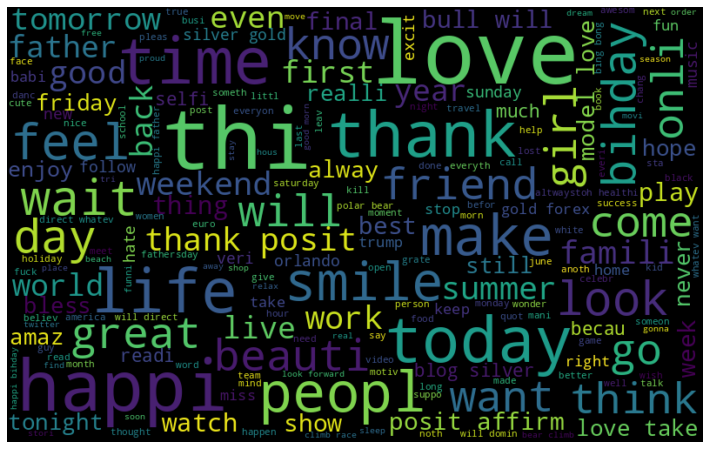

In [13]:
# visualize the frequent words
all_words = " ".join([sentence for sentence in df['clean_tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

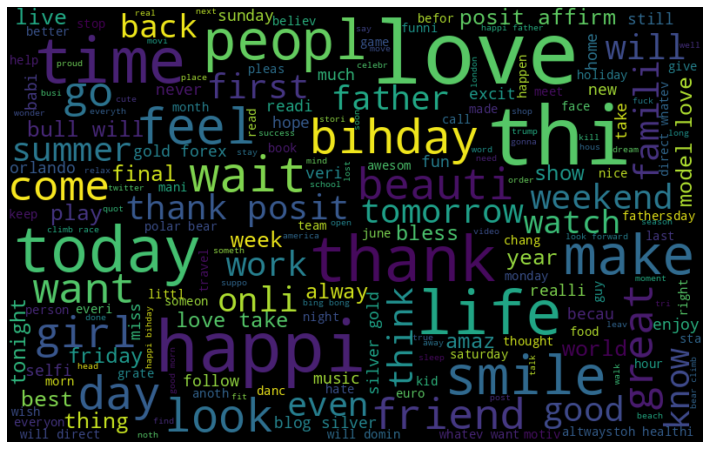

In [14]:
# frequent words visualization for +ve
all_words = " ".join([sentence for sentence in df['clean_tweet'][df['label']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

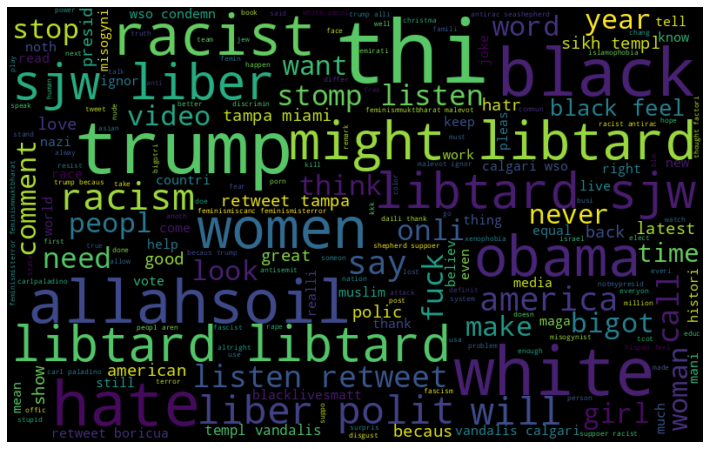

In [15]:
# frequent words visualization for -ve
all_words = " ".join([sentence for sentence in df['clean_tweet'][df['label']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
# extract the hashtag
def hashtag_extract(tweets):
    hashtags = []
    # loop words in the tweet
    for tweet in tweets:
        ht = re.findall(r"#(\w+)", tweet)
        hashtags.append(ht)
    return hashtags

In [17]:
# extract hashtags from non-racist/sexist tweets
ht_positive = hashtag_extract(df['clean_tweet'][df['label']==0])

# extract hashtags from racist/sexist tweets
ht_negative = hashtag_extract(df['clean_tweet'][df['label']==1])

In [18]:
ht_positive[:5]

[['run'], ['lyft', 'disapoint', 'getthank'], [], ['model'], ['motiv']]

In [19]:
# unnest list
ht_positive = sum(ht_positive, [])
ht_negative = sum(ht_negative, [])

In [20]:
ht_positive[:5]

['run', 'lyft', 'disapoint', 'getthank', 'model']

In [21]:
freq = nltk.FreqDist(ht_positive)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})
d.head()

,Hashtag,Count
0,run,72
1,lyft,2
2,disapoint,1
3,getthank,2
4,model,375


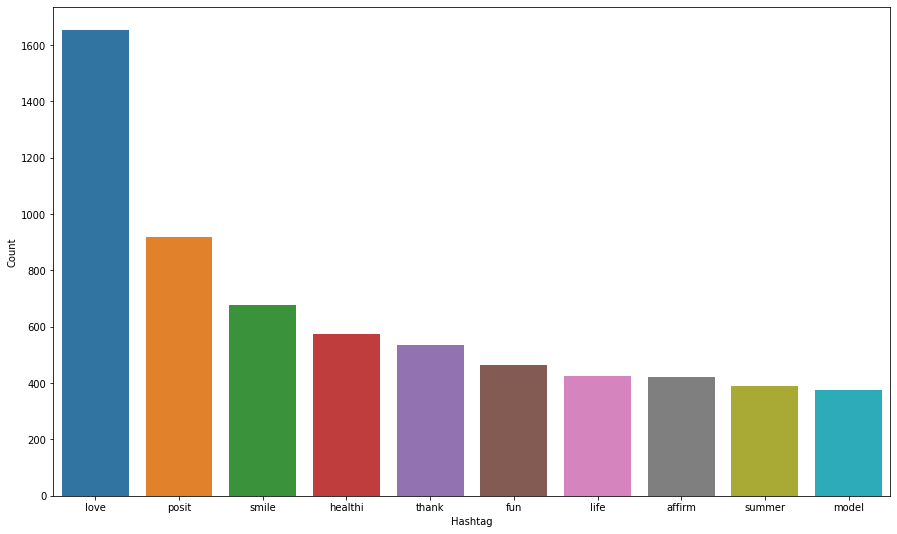

In [22]:
# select top 10 hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

In [23]:
freq = nltk.FreqDist(ht_negative)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})
d.head()

,Hashtag,Count
0,cnn,10
1,michigan,2
2,tcot,14
3,australia,6
4,opkillingbay,5


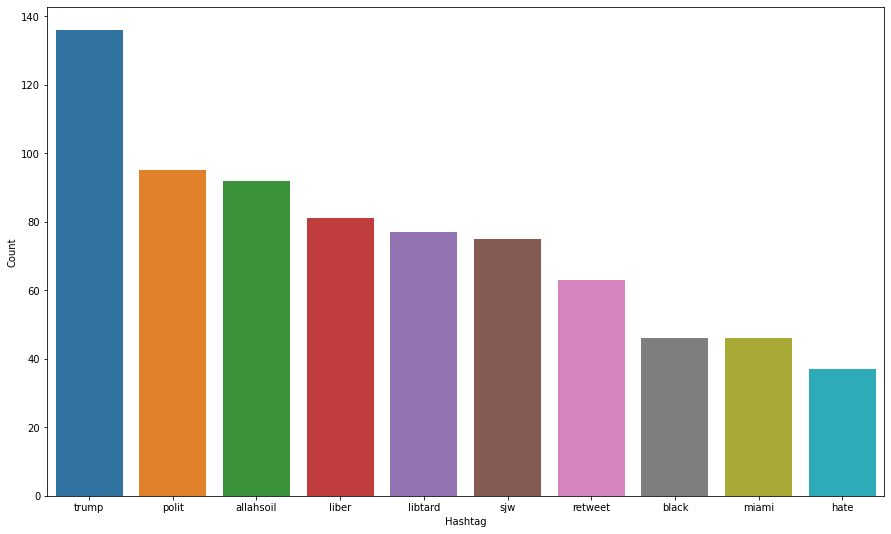

In [24]:
# select top 10 hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

In [25]:
# feature extraction
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(df['clean_tweet'])

In [26]:
#bow[0].toarray()

In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bow, df['label'], random_state=42, test_size=0.25)

In [28]:
#TRAINING
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

In [29]:
# training
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [30]:
# testing
pred = model.predict(x_test)
f1_score(y_test, pred)

0.49763033175355453

In [31]:
accuracy_score(y_test,pred)

0.9469403078463271

In [32]:
# use probability to get output
pred_prob = model.predict_proba(x_test)
pred = pred_prob[:, 1] >= 0.3
pred = pred.astype(np.int)

f1_score(y_test, pred)

0.5545722713864307

In [33]:
accuracy_score(y_test,pred)

0.9433112251282693

In [34]:
pred_prob[0][1] >= 0.3

False